In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import imp
import importlib
import os
from os import listdir
from os.path import isfile, join
import statsmodels.stats.multitest as smm
from pwas.shared_utils.util import get_parser_file_type, get_parser_directory_type, multipletests_with_nulls
import time 
from IPython.display import clear_output


/cs/labs/michall/roeizucker/fml_virt_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  """


In [94]:
#Import libraries
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted
from matplotlib import pyplot as plt
%matplotlib inline

# Definitions

## basic definitions

In [3]:
plt.rcParams['axes.facecolor'] = 'white'
SPECIFIC_PHENOTYPE = "I10"

In [4]:
# GWAS_CONSTANTS
base_dir = "/cs/labs/michall/roeizucker/10krun/runs/48:59/GWAS/results"
# base_dir = "/cs/labs/michall/roeizucker/10krun/runs/12:23/GWAS/results"
phen = SPECIFIC_PHENOTYPE
WORK_PATH = '/cs/labs/michall/roeizucker/10krun/runs/'
PHEN_PER_DIR = 12
GENE_FILE_PATH = '/cs/labs/michall/roeizucker/virt_env_install_test/genes_hg19.csv'

In [5]:
# for i in range(200):
#     df_aaa = pd.read_csv(f"/cs/labs/michall/roeizucker/virt_env_install_test/ukbb_imputation_gene_effect_scores/{i}.csv")
#     print(np.var(np.array(df_aaa["dominant"])))
# file_path = "/cs/labs/michall/roeizucker/remote_test/testush"
# with open(file_path) as file:
#     output = file.read()
# file_set = set(output.split("\n"))
# df = pd.read_csv("/cs/labs/michall/roeizucker/virt_env_install_test/genes_hg19.csv")
# our_genes = set(df["uniprot_id"])
# reduced_set = file_set - our_genes
# with open(r'/cs/labs/michall/roeizucker/not_viewd_by_PWAS', 'w') as fp:
#     for item in sorted(list(reduced_set)):
#         # write each item on a new line
#         fp.write("%s\n" % item)
#     print('Done')

# sorted(list(reduced_set))

In [6]:
def set_plot_lims(start,end,color='red'):
    plt.gca().set_xlim([start,end])
    plt.gca().set_ylim([start,end])
    x = list((plt.gca().get_xlim()))
    y = list((plt.gca().get_ylim()))
    plt.plot(x,y,linestyle='dashed',dashes=(5, 3),color=color,linewidth=1)
#     x = [0,end]
#     y = [5,5]
#     plt.plot(x,y,color='blue',linestyle='dashed')

#     y = [0,end]
#     x = [5,5]
#     plt.plot(x,y,color='blue',linestyle='dashed')


## GWAS definitions

In [7]:
def handle_df(df):
#     df['-logP'] = df['Z_STAT']
    df['-logP'] = -np.log10(df['P'])
    df['ind'] = df['POS']
    df = df.set_index(['#CHROM','POS','REF','ALT'])
    return df
    

In [8]:
def create_combined_gwas_datafrmes(base_dir,phen,chrom,female_p_range=4,male_p_range=4,all_p_range=4):
    try:
#         print(f"{base_dir}/{phen}_chr{chrom}.PHENO1.glm.logistic")
        male_df = pd.read_csv(f"{base_dir}/{phen}_M_chr{chrom}.PHENO1.glm.logistic",sep="\t")
        # male_df['-logP'] = -np.log10(male_df['P'])
        male_df = handle_df(male_df)

        female_df = pd.read_csv(f"{base_dir}/{phen}_F_chr{chrom}.PHENO1.glm.logistic",sep="\t")
        female_df = handle_df(female_df)

        both_df = pd.read_csv(f"{base_dir}/{phen}_chr{chrom}.PHENO1.glm.logistic",sep="\t")
    #     print("#" * 30)
    #     print(f"{base_dir}/{phen}_chr{chrom}.PHENO1.glm.logistic")
    #     print(both_df)
    #     print("#" * 30)
        both_df = handle_df(both_df)
    except pd.errors.EmptyDataError:
        return -1,-1,-1,-1
    except FileNotFoundError:
        return -1,-1,-1,-1
        
#     print(both_df.loc[(1,901922)])
 
    comb_df = pd.DataFrame()
    comb_df["male_neg_logP"] = male_df['-logP']
    comb_df["female_neg_logP"] = female_df['-logP']
    comb_df["both_neg_logP"] = both_df['-logP']
    
    comb_df["malez"] = male_df['Z_STAT']
    comb_df["femalez"] = female_df['Z_STAT']
    comb_df["bothz"] = both_df['Z_STAT']
    comb_df["ID"] =female_df["ID"]
    comb_df['ind'] = female_df['ind']
    comb_df = comb_df.dropna()
    x_labels.append(str(chrom))
#     x_labels_pos.append((comb_df['ind'].iloc[-1] - (comb_df['ind'].iloc[-1] - comb_df['ind'].iloc[0])/2))
#     comb_df = comb_df.query('female_neg_logP >=4 | male_neg_logP >=4')
    comb_df = comb_df.query('both_neg_logP >=3') #removed to bring everything

#     comb_df = comb_df.query('female_neg_logP >= both_neg_logP | male_neg_logP >=both_neg_logP')
    return male_df,female_df,both_df,comb_df


In [9]:
GWAS_outputs_path = "/cs/labs/michall/roeizucker/phewas_run/GWAS_results"
def create_multiple_GWAS_files():
    spec = importlib.util.spec_from_file_location("module.name", "/cs/labs/michall/roeizucker/10krun/phenotype_specs.py")
    foo = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(foo)
    old_specs = foo.specs
    new_specs = []
    for spec in old_specs:
    #     print(spec)
        new_specs.append(spec)
        spec_f = spec.copy()
        spec_f['name']+="_F"
        spec_f['sex_filter'] = 'F'
        spec_m = spec.copy()
        spec_m['name']+="_M"
        spec_m['sex_filter'] = 'M'
        new_specs.append(spec_f)
        new_specs.append(spec_m)

    counter = 0
    # print(new_specs)
    while counter < len(new_specs):
    #     create dir for current batch of phenotypes
        curr_counter = counter
        dir_name = WORK_PATH + str(counter) + ":" + str(counter + PHEN_PER_DIR - 1)
    #     print(dir_name)
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)
        specs_file = dir_name + "/phenotype_specs.py"
        spec = importlib.util.spec_from_file_location("module.name", specs_file)
        foo = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(foo)
        for spec in foo.specs:
            phen = spec["name"]
            if "_" not in spec["name"] and not os.path.isfile(f"{GWAS_outputs_path}/{phen}_gwas_results.csv"):
                clear_output(wait=True)
                print(phen)
                base_dir = dir_name + "/GWAS/results"
                dataframes = []
                for chrom in range(1,23):
                    male_df,female_df,both_df,comb_df = create_combined_gwas_datafrmes(base_dir,phen,chrom)
                    if  type(male_df) is int:
                        continue
                    dataframes.append(comb_df)
                if len(dataframes) > 0:
                    result = pd.concat(dataframes)
                    result.to_csv(f"{GWAS_outputs_path}/{phen}_gwas_results.csv")
#                 create_graphs_for_phenotype(dir_name + "/GWAS/results",spec["name"])

            counter+=1
create_multiple_GWAS_files()

N92


In [63]:
def pie_formater(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}% ({:d})".format(pct, absolute)

def find_sex_depandent_genes_for_snps(alpha, res):
    reg_sig, female_sig, male_sig = get_sig_snps_gendered(alpha,res)
    female_sig_genes = find_genes_for_snps(female_sig,genes_csv)
    male_sig_genes = find_genes_for_snps(male_sig,genes_csv)
    reg_sig_genes = find_genes_for_snps(reg_sig,genes_csv)
    return female_sig_genes, male_sig_genes, reg_sig_genes

def create_GWAS_to_gene_intersection_pie_chart(alpha,res,genes_csv):
    reg_sig, female_sig, male_sig = get_sig_snps_gendered(alpha,res)
    female_sig_genes, male_sig_genes, reg_sig_genes = find_sex_depandent_genes_for_snps(alpha, res)
    labels,values = create_intersection_groups(reg_sig_genes,female_sig_genes,male_sig_genes)
    plt.pie(values,labels=labels,autopct=lambda pct: pie_formater(pct, values))
    plt.title("GWAS gene distribution of relevant genes by sex, alpha=" + str(alpha))
    plt.show()

def create_GWAS_to_gene_intersection_venn_diagram(alpha,res,genes_csv):
    reg_sig, female_sig, male_sig = get_sig_snps_gendered(alpha,res)
    female_sig_genes, male_sig_genes, reg_sig_genes = find_sex_depandent_genes_for_snps(alpha, res)
    labels,values = create_intersection_groups(reg_sig_genes,female_sig_genes,male_sig_genes)
    venn3(subsets = (20, 10, 12, 10, 9, 4, 3), set_labels = ('Group A', 'Group B', 'Group C'), alpha = 0.5);
#     plt.pie(values,labels=labels,autopct=lambda pct: pie_formater(pct, values))
    
    plt.title("GWAS gene distribution of relevant genes by sex, alpha=" + str(alpha))
    plt.show()

In [11]:
def get_sig_snps_gendered(alpha,res):
    alpha = str(alpha)
    male_sig = res.query(' malep >=' + alpha)
    female_sig = res.query(' femalep >=' + alpha)
    reg_sig = res.query(' regp >=' + alpha)
    return reg_sig, female_sig, male_sig

In [12]:
def create_intersection_groups(reg_sig_genes,female_sig_genes,male_sig_genes):
    combined_only = reg_sig_genes.difference(female_sig_genes).difference(male_sig_genes)
    female_only = female_sig_genes.difference(reg_sig_genes).difference(male_sig_genes)
    male_only = female_sig_genes.difference(reg_sig_genes).difference(female_sig_genes)
    female_combined = female_sig_genes.intersection(reg_sig_genes).difference(male_sig_genes)
    male_combined = male_sig_genes.intersection(reg_sig_genes).difference(female_sig_genes)
    male_female = male_sig_genes.intersection(female_sig_genes).difference(reg_sig_genes)
    male_female_combined = male_sig_genes.intersection(female_sig_genes).intersection(reg_sig_genes)
    lables = ["combined only", "female only", "male only", "female-combined",
              "male-combined","male-female","male-female-combined"]
    values = [len(combined_only), len(female_only),len(male_only),len(female_combined),
             len(male_combined),len(male_female),len(male_female_combined)]
    new_labels = []
    new_values = []
    for ind ,val in enumerate(values):
        if val == 0:
#             lables[ind] = ""
            continue
        new_labels.append(lables[ind])
        new_values.append(val)
    return new_labels, new_values


In [13]:
def find_genes_for_snps(df,genes_csv):
    sig_genes = set()
    for index, row in df.iterrows():
        curr = (genes_csv.query("chr == '" + str(row["chr"]) + "' and cds_start <= " + str(row["ind"]) + "and cds_end >= " + str(row["ind"])))
        sig_genes.add(list(curr["uniprot_id"])[0])
    return sig_genes

def find_genes_for_snps_symbol(df,genes_csv):
    sig_genes = set()
    for index, row in df.iterrows():
        curr = (genes_csv.query("chr == '" + str(row["chr"]) + "' and cds_start <= " + str(row["ind"]) + "and cds_end >= " + str(row["ind"])))
        sig_genes.add(list(curr["symbol"])[0])
    return sig_genes

In [14]:
def create_graphs_for_phenotype(base_dir,phen):
    dataframes = []
    for chrom in range(1,23):
        male_df = pd.read_csv(f"{base_dir}/{phen}_M_chr{chrom}.PHENO1.glm.logistic",sep="\t")
        # male_df['-logP'] = -np.log10(male_df['P'])
        male_df = handle_df(male_df)

        female_df = pd.read_csv(f"{base_dir}/{phen}_F_chr{chrom}.PHENO1.glm.logistic",sep="\t")
        female_df = handle_df(female_df)

        comb_df = pd.DataFrame()
        comb_df["malep"] = male_df['-logP']
        comb_df["femalep"] = female_df['-logP']

        comb_df["malez"] = male_df['Z_STAT']
        comb_df["femalez"] = female_df['Z_STAT']
        comb_df['ind'] = female_df['ind']
        comb_df = comb_df.dropna()
        comb_df = comb_df.query('femalep >= 6 | malep >=6')
        dataframes.append(comb_df)
    #     comb_df.plot.scatter(x='male',y='female')
    #     plt.title(str( f"phen {phen} chr {chrom}"))
    #     plt.show()
    result = pd.concat(dataframes)
    # result = result.query('female >= 2 | male >=2')
    result.plot.scatter(x='malez',y='femalez')
    plt.title(phen + " Z scatter")
    set_plot_lims(-10,10)
    plt.show()
    result = pd.concat(dataframes)

    result.plot.scatter(x='malep',y='femalep')
    plt.title(phen + " P scatter")
#     plt.title(str( f"phen {phen} chr {chrom}"))
    set_plot_lims(0,20)

    plt.show()

    delta = np.array(result['malez']) / np.array(result['femalez'])
    plt.hist(delta)
    plt.title(phen + " Z hist")
    plt.show()

In [15]:
def create_full_dataframe(base_dir,phen):
    dataframes = []
    for chrom in range(1,23):
        male_df = pd.read_csv(f"{base_dir}/{phen}_M_chr{chrom}.PHENO1.glm.logistic",sep="\t")
        # male_df['-logP'] = -np.log10(male_df['P'])
        male_df = handle_df(male_df)

        female_df = pd.read_csv(f"{base_dir}/{phen}_F_chr{chrom}.PHENO1.glm.logistic",sep="\t")
        female_df = handle_df(female_df)
        
        reg_df = pd.read_csv(f"{base_dir}/{phen}_chr{chrom}.PHENO1.glm.logistic",sep="\t")
        reg_df = handle_df(reg_df)
        
        comb_df = pd.DataFrame()
        comb_df["malep"] = male_df['-logP']
        comb_df["femalep"] = female_df['-logP']
        comb_df["regp"]  = reg_df['-logP']
        comb_df["malez"] = male_df['Z_STAT']
        comb_df["femalez"] = female_df['Z_STAT']
        comb_df["regz"]  = reg_df['Z_STAT']
        
        comb_df['ind'] = female_df['ind']
        comb_df["ID"] =female_df["ID"]
        comb_df["chr"] = chrom
        
#         comb_df = comb_df.dropna()
#         comb_df = comb_df.query('femalep >= 6 | malep >=6')
        dataframes.append(comb_df)
    #     comb_df.plot.scatter(x='male',y='female')
    #     plt.title(str( f"phen {phen} chr {chrom}"))
    #     plt.show()
    result = pd.concat(dataframes)
    return result

## PWAS functions

In [16]:
def add_nans_to_fdr(df,rej,pval_corr):    
    a = list(pval_corr)
    rej = list(rej)
    
    for i in range(len(df) - len(pval_corr)):
        a.append(float("nan"))
        rej.append(False)
    
    return rej,a

def add_fdr_to_df(df,inharitance_type,alpha,fdr_leval,master_df,phen):
    rej, pval_corr = smm.multipletests(list(df[inharitance_type + "_pval"].dropna()), alpha=alpha, method='fdr_bh')[:2]
    rej,pval_corr = add_nans_to_fdr(df,rej,pval_corr)
    df[phen + "_" + inharitance_type + "_qval_" + fdr_leval] = pval_corr
    df[phen + "_" + inharitance_type + "_fdr_significance_" + fdr_leval] = rej
    master_df[phen + "_" + inharitance_type + "_qval_" + fdr_leval] = df[phen + "_recessive_qval_" + fdr_leval]
    master_df[phen + "_" + inharitance_type + "_fdr_significance_" + fdr_leval] = df[phen + "_recessive_fdr_significance_" + fdr_leval]


In [17]:
pwas_base_dir = "/cs/labs/michall/roeizucker/10krun/results"
onlyfiles = [f for f in listdir(pwas_base_dir) if isfile(join(pwas_base_dir, f))]
master_df = pd.DataFrame()
phenotypes = []
alpha_reg = 0.05
alpha_lax = 0.1
for file in onlyfiles:
#     break
    phen = file.replace(".csv","")
    path = join(pwas_base_dir, file)
    df = pd.read_csv(path)
    df.set_index("uniprot_id", inplace=True)
#     df.set_index('uniprot_id')
    
    phenotypes.append(phen)
    if len(df) > len(master_df):
        df[phen + "_fdr_qval"] = df["fdr_qval"]
        master_df = pd.concat([master_df, df[phen + "_fdr_qval"]], axis=1)
    else:
        master_df[phen + "_fdr_qval"] = df["fdr_qval"]
#     qvals = df[phen + "_fdr_qval"]
    
#     if phen == 'I10':
    master_df[phen + "_dominant_cohen_d"] = df["dominant_cohen_d"]
    master_df[phen + "_recessive_cohen_d"] = df["recessive_cohen_d"]
    master_df[phen + "_combined_pval"] = df["combined_pval"]
    master_df[phen + "_fdr_significance"] = df["fdr_significance"]
    master_df[phen + "_recessive_pval"] = df["recessive_pval"]
    master_df[phen + "_dominant_pval"] = df["dominant_pval"]
    add_fdr_to_df(df,"recessive",alpha_reg,"reg",master_df,phen)
    add_fdr_to_df(df,"recessive",alpha_lax,"lax",master_df,phen)
    add_fdr_to_df(df,"dominant",alpha_reg,"reg",master_df,phen)
    add_fdr_to_df(df,"dominant",alpha_lax,"lax",master_df,phen)    
print("Done")

/cs/labs/michall/roeizucker/fml_virt_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()
/cs/labs/michall/roeizucker/fml_virt_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/cs/labs/michall/roeizucker/fml_virt_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

Done


# GWAS RESULTS

## GWAS for a single chromosome, for a single phenotype (I10)

### general data

In [18]:
res = create_full_dataframe(base_dir,"I10")
# create_graphs_for_phenotype(base_dir,phen)

In [19]:
res

malep   femalep      regp     malez   femalez  \
#CHROM POS      REF ALT                                                     
1      69428    G   T    1.481335  0.165642  1.133165  2.131940  0.408506   
       69487    A   G         NaN  0.077377  0.095114       NaN  0.205986   
       69496    A   G         NaN       NaN       NaN       NaN       NaN   
       69521    A   T    0.103602  0.382838  0.173477 -0.269211  0.816606   
       69569    C   T    0.013846  0.438277  0.284416  0.039337  0.906785   
...                           ...       ...       ...       ...       ...   
22     51183430 G   C         NaN       NaN       NaN       NaN       NaN   
       51183575 A   C         NaN  0.038292  0.064091       NaN -0.105971   
       51183576 A   G    0.154610  0.246223  0.300552 -0.384687 -0.572101   
       51183608 C   G         NaN  0.000481  0.606860       NaN  0.001388   
       51216386 G   T         NaN       NaN       NaN       NaN       NaN   

                             regz       ind           ID  chr  
#CHROM POS      REF ALT                                        
1      69428    G   T    1.789140     69428  rs140739101    1  
       69487    A   G    0.249058     69487  rs568226429    1  
       69496    A   G         NaN     69496  rs150690004    1  
       69521    A   T    0.425199     69521  rs553724620    1  
       69569    C   T    0.644119     69569    rs2531267    1  
...                           ...       ...          ...  ...  
22     51183430 G   C         NaN  51183430  rs547756808   22  
       51183575 A   C   -0.172815  51183575  rs531270968   22  
       51183576 A   G   -0.673623  51183576  rs201653264   22  
       51183608 C   G   -1.157050  51183608  rs571073375   22  
       51216386 G   T         NaN  51216386   rs75855559   22  

[290220 rows x 9 columns]

In [20]:
# vals = (list(res["ID"]))
# counter = 0
# for val in vals:
#     if "rs" not in val:
#         counter+=1
# print(counter)
# pd.set_option('display.max_rows', 1000)
import collections

# print(res.head(100))
ls = list(res.index)
len(([item for item, count in collections.Counter(ls).items() if count > 1]))


0

### Numeric Data

In [21]:
alpha = 7
genes_csv = pd.read_csv(GENE_FILE_PATH)
reg_sig, female_sig, male_sig = get_sig_snps_gendered(alpha,res)
print("len", len(res))
print("len male sig",len(male_sig))
print("len female sig",len(female_sig))
print("len reg sig",len(reg_sig))

len 290220
len male sig 2
len female sig 7
len reg sig 25


In [22]:
genes_csv

,Unnamed: 0,uniprot_id,symbol,name,refseq_ids,chr,cds_start,cds_end
0,0,A0A075B6H7,IGKV3-7,immunoglobulin kappa variable 3-7 (non-functio...,['NG_000834'],2,89277987,89278503
1,1,A0A075B6H9,IGLV4-69,immunoglobulin lambda variable 4-69,['NG_000002'],22,22385392,22385870
2,2,A0A075B6I0,IGLV8-61,immunoglobulin lambda variable 8-61,['NG_000002'],22,22453156,22453622
3,3,A0A075B6I1,IGLV4-60,immunoglobulin lambda variable 4-60,['NG_000002'],22,22516592,22517074
4,4,A0A075B6I4,IGLV10-54,immunoglobulin lambda variable 10-54,['NG_000002'],22,22569197,22569660
...,...,...,...,...,...,...,...,...
18130,18130,Q9Y6Z2,LINC01558,long intergenic non-protein coding RNA 1558,['NR_026773'],6,168188247,168191756
18131,18131,Q9Y6Z7,COLEC10,collectin subfamily member 10,['NM_001324095'],8,120079521,120118427
18132,18132,S4R3P1,MTRNR2L13,MT-RNR2 like 13,['NG_023160'],4,117220957,117221028
18133,18133,S4R3Y5,MTRNR2L11,MT-RNR2 like 11,['NG_023152'],1,238107555,238107626


### Gene Data

In [23]:

# print(genes_csv.head(2))
female_sig_genes = find_genes_for_snps(female_sig,genes_csv)
male_sig_genes = find_genes_for_snps(male_sig,genes_csv)
reg_sig_genes = find_genes_for_snps(reg_sig,genes_csv)
labels,values = create_intersection_groups(reg_sig_genes,female_sig_genes,male_sig_genes)

In [24]:

print("female count: ",len((female_sig_genes)))
print("male count: ",len((male_sig_genes)))
print("reg count: ",len((reg_sig_genes)))
print("reg, female intersection: ",len(reg_sig_genes.intersection(female_sig_genes)))
print("reg, male intersection: ",len(reg_sig_genes.intersection(male_sig_genes)))
print("male, female intersection: ",len(male_sig_genes.intersection(female_sig_genes)))
print("all intersection: ",len(male_sig_genes.intersection(female_sig_genes).intersection(reg_sig_genes)))

female count:  7
male count:  2
reg count:  23
reg, female intersection:  6
reg, male intersection:  2
male, female intersection:  2
all intersection:  2


In [127]:
def create_intersection_groups_for_venn(reg_sig_genes,female_sig_genes,male_sig_genes):
    combined_only = reg_sig_genes.difference(female_sig_genes).difference(male_sig_genes)
    female_only = female_sig_genes.difference(reg_sig_genes).difference(male_sig_genes)
    male_only = female_sig_genes.difference(reg_sig_genes).difference(female_sig_genes)
    female_combined = female_sig_genes.intersection(reg_sig_genes).difference(male_sig_genes)
    male_combined = male_sig_genes.intersection(reg_sig_genes).difference(female_sig_genes)
    male_female = male_sig_genes.intersection(female_sig_genes).difference(reg_sig_genes)
    male_female_combined = male_sig_genes.intersection(female_sig_genes).intersection(reg_sig_genes)
    lables = ["combined only", "female only", "male only", "female-combined",
              "male-combined","male-female","male-female-combined"]
    values = [len(combined_only), len(female_only),len(female_combined),len(male_only),
             len(male_combined),len(male_female),len(male_female_combined)]
    return  values


def create_GWAS_to_gene_intersection_venn_diagram(res,genes_csv):
    reg_sig, female_sig, male_sig = get_sig_snps_gendered(alpha,res)
    female_sig_genes, male_sig_genes, reg_sig_genes = find_sex_depandent_genes_for_snps(alpha, res)
    values = create_intersection_groups_for_venn(reg_sig_genes,female_sig_genes,male_sig_genes)
    out = venn3_unweighted(subsets = values, set_labels = ('Combined', 'Female', 'Male'), alpha = 0.5);
    for text in out.subset_labels:
        text.set_fontsize(15)
    for text in out.set_labels:
        text.set_fontsize(15)
#     venn3(subsets = (1,2,3,4,5,6,7), set_labels = ('Group A', 'Group B', 'Group C'), alpha = 0.5);
    
#     plt.pie(values,labels=labels,autopct=lambda pct: pie_formater(pct, values))
#     print(values)
#     plt.title("GWAS gene distribution of relevant genes by sex, alpha=" + str(alpha))
    plt.title(f"Unique GWAS\ngenes intersection",rotation='vertical',x=-0.1,y=0.1,fontsize=20)
    plt.show()
    

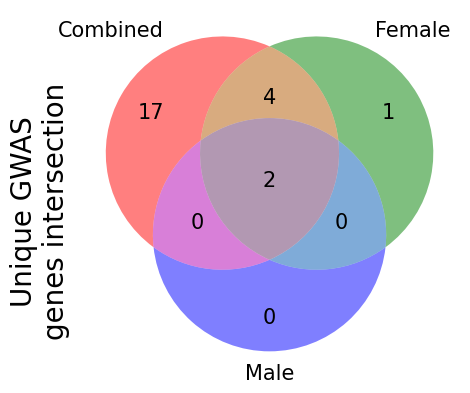

In [128]:
# create_GWAS_to_gene_intersection_pie_chart(3,res,genes_csv)
# create_GWAS_to_gene_intersection_pie_chart(5,res,genes_csv)
# create_GWAS_to_gene_intersection_pie_chart(6,res,genes_csv)
# create_GWAS_to_gene_intersection_pie_chart(7,res,genes_csv)
create_GWAS_to_gene_intersection_venn_diagram(res,genes_csv)

### gwas/pwas interaction

In [143]:
def create_pwas_sex_depandent_sig_genes_sets(master_df):
    reg_pwas_set = set(master_df.query("I10_1_fdr_significance == True").index.values)
    male_pwas_set = set(master_df.query("I10_M_fdr_significance == True").index.values)
    female_pwas_set = set(master_df.query("I10_F_fdr_significance == True").index.values)
    return reg_pwas_set, male_pwas_set, female_pwas_set

def create_GWAS_PWAS_intersection_pie_chart(gwas_set, pwas_set, sex,alpha):
    intersection = gwas_set.intersection(pwas_set)
    gwas_only = gwas_set.difference(pwas_set)
    pwas_only = pwas_set.difference(gwas_set)
    print(len(pwas_set))
    vals = [len(intersection),len(gwas_only),len(pwas_only)]
    labels = ["intersection","gwas only", "pwas only"]
    plt.pie(vals,labels=labels,autopct=lambda pct: pie_formater(pct, vals))
    plt.title(f"{sex} PWAS GWAS significant gene intersection, alpha={alpha}")
    plt.show()
    pass

def create_GWAS_PWAS_intersection_venn(gwas_set, pwas_set):
    intersection = gwas_set.intersection(pwas_set)
    gwas_only = gwas_set.difference(pwas_set)
    pwas_only = pwas_set.difference(gwas_set)
    vals = [len(pwas_only),len(gwas_only),len(intersection)]
    print(len(pwas_set))
    print(vals)
#     labels = ["intersection","gwas only", "pwas only"]
#     plt.pie(vals,labels=labels,autopct=lambda pct: pie_formater(pct, vals))
    out = venn2_unweighted(subsets = vals, set_labels = ('PWAS', 'GWAS'))
    for text in out.subset_labels:
        text.set_fontsize(15)
    for text in out.set_labels:
        text.set_fontsize(15)

    plt.title(f"PWAS-GWAS\n gene intersection",rotation='vertical',x=-0.1,y=0.11,fontsize=20)
    plt.show()


def print_GWAS_PWAS_intersection(gwas_set, pwas_set, sex,alpha):
    intersection = gwas_set.intersection(pwas_set)
    gwas_only = gwas_set.difference(pwas_set)  
    pwas_only = pwas_set.difference(gwas_set)
    print("sex:",sex)
    print("gwas_set:",gwas_set)
    print("pwas_set:",pwas_set)
#     print("intersection",intersection)
#     print("intersection:")
#     vals = [len(intersection),len(gwas_only),len(pwas_only)]
#     labels = ["intersection","gwas only", "pwas only"]
#     plt.pie(vals,labels=labels,autopct=lambda pct: pie_formater(pct, vals))
#     plt.title(f"{sex} PWAS GWAS significant gene intersection, alpha={alpha}")
#     plt.show()

70
[54, 7, 16]


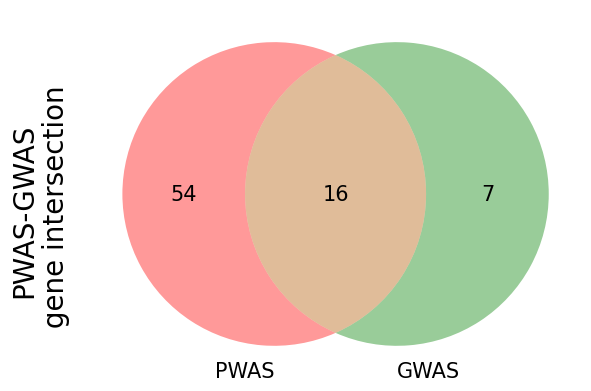

In [144]:


gwas_female_sig_genes, gwas_male_sig_genes, gwas_reg_sig_genes = find_sex_depandent_genes_for_snps(alpha, res)
reg_pwas_set, male_pwas_set, female_pwas_set = create_pwas_sex_depandent_sig_genes_sets(master_df)
# create_GWAS_PWAS_intersection_pie_chart(gwas_reg_sig_genes,reg_pwas_set, "combined",alpha)
# create_GWAS_PWAS_intersection_pie_chart(gwas_female_sig_genes,female_pwas_set, "female",alpha)
# create_GWAS_PWAS_intersection_pie_chart(gwas_male_sig_genes,male_pwas_set, "male",alpha)
create_GWAS_PWAS_intersection_venn(gwas_reg_sig_genes,reg_pwas_set)
# create_GWAS_PWAS_intersection_venn(gwas_female_sig_genes,female_pwas_set, "female",alpha)
# create_GWAS_PWAS_intersection_venn(gwas_male_sig_genes,male_pwas_set, "male",alpha)

# print_GWAS_PWAS_intersection(gwas_reg_sig_genes,reg_pwas_set, "combined",alpha)
# print_GWAS_PWAS_intersection(gwas_female_sig_genes,female_pwas_set, "female",alpha)
# print_GWAS_PWAS_intersection(gwas_male_sig_genes,male_pwas_set, "male",alpha)
# input()
# print(gwas_male_sig_genes,male_pwas_set)
# create_GWAS_PWAS_intersection_pie_chart(gwas_male_sig_genes,male_pwas_set, "male",alpha)

In [28]:
reg_pwas_set, male_pwas_set, female_pwas_set
female_pwas_set - reg_pwas_set

{'B2CW77', 'O60500', 'Q00056', 'Q96DD7'}

In [ ]:

reg_intersection_count = len(set(master_df.query("I10_1_fdr_significance == True").index.values).intersection(reg_sig_genes))
female_intersection_count = len(set(master_df.query("I10_F_fdr_significance == True").index.values).intersection(female_sig_genes))
male_intersection_count = len(set(master_df.query("I10_M_fdr_significance == True").index.values).intersection(male_sig_genes))



reg_pwas_count = len(set(master_df.query("I10_1_fdr_significance == True").index.values))
reg_gwas_count = len(reg_sig_genes)
male_pwas_count = len(set(master_df.query("I10_M_fdr_significance == True").index.values))
male_gwas_count = len(male_sig_genes)
print((male_intersection_count))
female_pwas_count = len(set(master_df.query("I10_F_fdr_significance == True").index.values))
female_gwas_count = len(female_sig_genes)

print("reg intersection count: ", reg_intersection_count)
print("reg intersection PWAS rate: ", (reg_intersection_count / reg_pwas_count))
print("reg intersection GWAS rate: ", (reg_intersection_count / reg_gwas_count))

print("female intersection",len(set(master_df.query("I10_F_fdr_significance == True").index.values).intersection(female_sig_genes)))
print("female intersection PWAS rate: ", (female_intersection_count / female_pwas_count))
print("female intersection GWAS rate: ", (female_intersection_count / female_gwas_count))

print("male intersection", len(set(master_df.query("I10_M_fdr_significance == True").index.values).intersection(male_sig_genes)))
print("male intersection PWAS rate: ", (male_intersection_count / male_pwas_count))
print("male intersection GWAS rate: ", (male_intersection_count / male_gwas_count))



In [ ]:
print(PHEN_PER_DIR)

### manhattan plot

In [ ]:
def add_genes_for_snps_symbol(df,genes_csv):
#     sig_genes = set()
#     for index, row in df.iterrows():
#         curr = (genes_csv.query("chr == '" + str(row["chr"]) + "' and cds_start <= " + str(row["ind"]) + "and cds_end >= " + str(row["ind"])))
#         row["gene"] = list(curr["symbol"])[0]
# #         sig_genes.add(list(curr["symbol"])[0])
#     return sig_genes
    sig_genes = set()
    for index, row in df.iterrows():
        curr = (genes_csv.query("chr == '" + str(row["chr"]) + "' and cds_start <= " + str(row["ind"]) + "and cds_end >= " + str(row["ind"])))
#         sig_genes.add(list(curr["uniprot_id"])[0])
#         row["gene"] = list(curr["symbol"])[0]
#         df.loc[index,"gene"] = list(curr["symbol"])[0]
#         print(index)
        if len(list(curr["symbol"])) == 0:
            df.loc[index,"gene"] = "no gene found"
            df.loc[index,"length"] = -1
            
        else:
            df.loc[index,"gene"] = str(list(curr["symbol"])[0])
#     cds_start  cds_end
            df.loc[index,"length"] = int(list(curr["cds_end"])[0]) - int(list(curr["cds_start"])[0])
        
colors = ['red','green','blue', 'yellow']
x_labels = []
x_labels_pos = []
dataframes = []
phen = SPECIFIC_PHENOTYPE
for chrom in range(1,23):
# for chrom in range(1,3):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    male_df,female_df,both_df,comb_df = create_combined_gwas_datafrmes(base_dir,phen,chrom)
    comb_df.plot(kind='scatter', x='ind', y='male_neg_logP',color="blue", ax=ax)
    comb_df.plot(kind='scatter', x='ind', y='female_neg_logP',color="red", ax=ax)
    comb_df.plot(kind='scatter', x='ind', y='both_neg_logP',color="lightgray", ax=ax)
    comb_df["chr"] = chrom
    dataframes.append(comb_df)
    plt.title(f"chr {chrom}")
    plt.show()
result = pd.concat(dataframes)
result["gene"] = ""
result["length"] = 0
add_genes_for_snps_symbol(result,genes_csv)
result.to_csv(f"{base_dir}/{phen}_gwas_results.csv")
print("path:", f"{base_dir}/{phen}_gwas_results.csv")

In [ ]:
df2 = result.groupby(['gene'])['gene'].count()
# wanted_genes = list(pd.DataFrame(df2).query("gene > 5").index)
wanted_genes = list(pd.DataFrame(df2).index)

# print(wanted_genes)
pd.set_option('display.max_rows', 400)
df2
# result[result['gene']]
# result[result["gene"].isin(wanted_genes)].sort_values("length")

In [ ]:
len(result.gene.unique())

### I10 chr 19 study

In [ ]:
chrom = 19
male_df,female_df,both_df,comb_df = create_combined_gwas_datafrmes(base_dir,phen,chrom)

print(result.sort_values(by='both_neg_logP',ascending=False).head(10))

## General data for multiple chromosomes, and all phenotypes

In [ ]:
spec = importlib.util.spec_from_file_location("module.name", "/cs/labs/michall/roeizucker/10krun/phenotype_specs.py")
foo = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo)
old_specs = foo.specs
new_specs = []
for spec in old_specs:
#     print(spec)
    new_specs.append(spec)
    spec_f = spec.copy()
    spec_f['name']+="_F"
    spec_f['sex_filter'] = 'F'
    spec_m = spec.copy()
    spec_m['name']+="_M"
    spec_m['sex_filter'] = 'M'
    new_specs.append(spec_f)
    new_specs.append(spec_m)

counter = 0
# print(new_specs)
while counter < len(new_specs):
#     create dir for current batch of phenotypes
    curr_counter = counter
    dir_name = WORK_PATH + str(counter) + ":" + str(counter + PHEN_PER_DIR - 1)
#     print(dir_name)
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    specs_file = dir_name + "/phenotype_specs.py"
    spec = importlib.util.spec_from_file_location("module.name", specs_file)
    foo = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(foo)
    for spec in foo.specs:
        if "_" not in spec["name"]:
            create_graphs_for_phenotype(dir_name + "/GWAS/results",spec["name"])

        counter+=1

# PWAS RESULTS

## Create Dataset

In [ ]:
pwas_base_dir = "/cs/labs/michall/roeizucker/10krun/results"
onlyfiles = [f for f in listdir(pwas_base_dir) if isfile(join(pwas_base_dir, f))]
master_df = pd.DataFrame()
phenotypes = []
alpha_reg = 0.05
alpha_lax = 0.1
for file in onlyfiles:
    phen = file.replace(".csv","")
    path = join(pwas_base_dir, file)
    df = pd.read_csv(path)
    df.set_index("uniprot_id", inplace=True)
#     df.set_index('uniprot_id')
    
    phenotypes.append(phen)
    if len(df) > len(master_df):
        df[phen + "_fdr_qval"] = df["fdr_qval"]
        master_df = pd.concat([master_df, df[phen + "_fdr_qval"]], axis=1)
    else:
        master_df[phen + "_fdr_qval"] = df["fdr_qval"]
#     qvals = df[phen + "_fdr_qval"]
    
#     if phen == 'I10':
    master_df[phen + "_dominant_cohen_d"] = df["dominant_cohen_d"]
    master_df[phen + "_recessive_cohen_d"] = df["recessive_cohen_d"]
    master_df[phen + "_combined_pval"] = df["combined_pval"]
    master_df[phen + "_fdr_significance"] = df["fdr_significance"]
    master_df[phen + "_recessive_pval"] = df["recessive_pval"]
    master_df[phen + "_dominant_pval"] = df["dominant_pval"]
#     rej, pval_corr = smm.multipletests(list(df.dropna()["combined_pval"]), alpha=alpha_reg, method='fdr_i')[:2]
#     rej,pval_corr = add_nans_to_fdr(df,rej,pval_corr)
#     df["rej"] = rej
#     df["pval_corr"] = pval_corr
    
#     print(df.head())
#     input()
#     print(smm.fdrcorrection(list(df["combined_pval"]), alpha=alpha_lax, method='i'))
#     inharitance_type = "recessive"
#     alpha = alpha_reg
#     fdr_leval = "reg"
    add_fdr_to_df(df,"recessive",alpha_reg,"reg",master_df,phen)
    add_fdr_to_df(df,"recessive",alpha_lax,"lax",master_df,phen)
    add_fdr_to_df(df,"dominant",alpha_reg,"reg",master_df,phen)
    add_fdr_to_df(df,"dominant",alpha_lax,"lax",master_df,phen)    
print("Done")

## compare old with new calculations

In [ ]:

df = pd.read_csv("/cs/labs/michall/roeizucker/10krun/results/I10.csv")
df.set_index("uniprot_id", inplace=True)

print((df["fdr_qval"])[0:5])
print((master_df["I10_fdr_qval"]["Q9UQQ2"]))
print((master_df["I10_1_fdr_qval"]["Q9UQQ2"]))
# rej, pval_corr = smm.multipletests(sorted(master_df["I10_combined_pval"].dropna()), alpha=0.05, method='fdr_n')[:2]
rej, pval_corr = smm.multipletests(list(master_df["I10_combined_pval"].dropna()), alpha=0.05, method='fdr_bh')[:2]

In [ ]:
onlyfiles = [f for f in listdir(pwas_base_dir) if isfile(join(pwas_base_dir, f))]
master_df_cohen_d_dom = pd.DataFrame()
for file in onlyfiles:
    path = join(pwas_base_dir, file)
    df = pd.read_csv(path)
    df.set_index("uniprot_id", inplace=True)
#     df.set_index('uniprot_id')
    master_df_cohen_d_dom[file] = df["dominant_cohen_d"]
print("Done")

In [ ]:
pairs = []
for key in master_df_cohen_d_dom.columns:
    if "_" not in key and key.replace(".csv","_1.csv") in master_df_cohen_d_dom.columns:
        pairs.append((key,key.replace(".csv","_1.csv")))
        master_df_cohen_d_dom[key.replace(".csv","") + "_log"] = -np.log10(master_df_cohen_d_dom[key])
        master_df_cohen_d_dom[key.replace(".csv","_1") + "_log"] = -np.log10(master_df_cohen_d_dom[key.replace(".csv","_1.csv")])
print("Done")

In [ ]:
pairs = []
for key in master_df.columns:
    if "_" not in key and key.replace(".csv","_1.csv") in master_df.columns:
        pairs.append((key,key.replace(".csv","_1.csv")))
        print(key)
        master_df[key.replace(".csv","") + "_log"] = -np.log10(master_df[key])
        master_df[key.replace(".csv","_1") + "_log"] = -np.log10(master_df[key.replace(".csv","_1.csv")])
print("Done")

In [ ]:
# master_df_cohen_d_dom[master_df_cohen_d_dom.isnull().any(axis=1)]
# print([x for x in list(master_df.columns) if "C50" in x])

## Compare Old and new combined sex by P-value

In [ ]:
# key = "H26.csv"
# pairs.append(("",key.replace(".csv","_1.csv")))
# master_df[key.replace(".csv","_2") + "_log"] = -np.log10(master_df[key.replace(".csv","_2.csv")])
# master_df[key.replace(".csv","_1") + "_log"] = -np.log10(master_df[key.replace(".csv","_1.csv")])


In [ ]:
# print((master_df["C50_log"].sort_values(ascending=False)))
# # print(master_df["C50.csv"])

In [ ]:
# # print(master_df.columns)
# for pair in pairs:
#     print(pair[0])
#     master_df.plot.scatter(x=pair[0].replace(".csv","") + "_log",y=pair[1].replace(".csv","") + "_log")
#     plt.xlim([0, 10])
#     plt.ylim([0, 10])
#     plt.show()
# #     reg = -np.log(master_df[pair[0]])
# #     new = -np.log(master_df[pair[1]])
# #     plt.title(pair[0])
# #     plt.scatter(reg,new)
# #     plt.show()

### rerun comparrison 

In [ ]:

# pair = ("H26_1.csv","H26_2.csv")
# master_df.plot.scatter(x=pair[0].replace(".csv","") + "_log",y=pair[1].replace(".csv","") + "_log")
# plt.show()


## Compare Old and new combined sex by P-value - sig only

In [ ]:
# for pair in pairs:
    
#     print(pair[0])
# #     new_master = master_df.query("(" + pair[0].replace(".csv","") + "_log > 3) or ("+ pair[1].replace(".csv","") + "_log > 3)")
#     new_master = master_df
#     new_master.plot.scatter(x=pair[0].replace(".csv","") + "_log",y=pair[1].replace(".csv","") + "_log")
#     plt.xlim([0, 10])
#     plt.ylim([0, 10])
# #     plt.gca().set_xlim(left=0)
# #     plt.gca().set_ylim(bottom=0)
#     plt.show()

## Compare Old and new combined sex by cohen D dom

In [ ]:
# for pair in pairs:
    
#     print(pair[0])
# #     new_master = master_df.query("(" + pair[0].replace(".csv","") + "_log > 3) or ("+ pair[1].replace(".csv","") + "_log > 3)")
#     new_master = master_df.query("(" + pair[0].replace(".csv","") + "_log > 3) or ("+ pair[1].replace(".csv","") + "_log > 3)")
#     new_master.plot.scatter(x=pair[0],y=pair[1])
#     plt.xlim([-1, 1])
#     plt.ylim([-1, 1])
# #     plt.gca().set_xlim(left=0)
# #     plt.gca().set_ylim(bottom=0)
#     plt.show()

## Compare males and females by P-value

In [ ]:
pairs = []
alpha = "0.05"
for key in phenotypes:
    if key + "_M_fdr_significance" in master_df.columns and key+ "_F_fdr_significance" in master_df.columns:
        pairs.append((key + "_M",key + "_F"))
        master_df[key +"_M_combined_pval" + "_minus_log"] = -np.log10(master_df[key +"_M_combined_pval"])
        master_df[key +"_F_combined_pval" + "_minus_log"] = -np.log10(master_df[key +"_F_combined_pval"])
for pair in pairs:
    
    if SPECIFIC_PHENOTYPE is not None and pair[0] != SPECIFIC_PHENOTYPE + "_M":
        continue
    print(pair[0][:-2])
#     new_master = master_df.query("(" + pair[0] + "_fdr_significance == True) or ("+ pair[1] + "_fdr_significance == True)")
    new_master = master_df.query("(" + pair[0] + "_fdr_qval <="+alpha+") or ("+ pair[1] + "_fdr_qval <="+alpha+")")
    
    new_master.plot.scatter(x=pair[0]+"_combined_pval" + "_minus_log",y=pair[1]+"_combined_pval" + "_minus_log",color="blue",s=50, alpha=0.5)
    set_plot_lims(0,40)
    plt.title(f"{pair[0]} Male/Female\noverall genes:{len(new_master)} (alpha="+alpha+")")
    plt.xlabel(f"{pair[0]}: -log10 hybrid p-val")
    plt.ylabel(f"{pair[1]}: -log10 hybrid p-val")
#     plt.gca().set_xlim(left=0)
#     plt.gca().set_ylim(bottom=0)
#     plt.gca().set_xlim([0,10])
#     plt.gca().set_ylim([0,10])
#     x = list((plt.gca().get_xlim()))
#     y = list((plt.gca().get_ylim()))
#     plt.plot(x,y,color='red')
#     set_plot_lims(0,10)
    plt.show()
    

## Compare males and females by Q-value

### regular

In [ ]:
pairs = []
for key in phenotypes:
    if key + "_M_fdr_significance" in master_df.columns and key+ "_F_fdr_significance" in master_df.columns:
        pairs.append((key + "_M",key + "_F"))
        master_df[key +"_M_fdr_qval" + "_minus_log"] = -np.log10(master_df[key +"_M_fdr_qval"])
        master_df[key +"_F_fdr_qval" + "_minus_log"] = -np.log10(master_df[key +"_F_fdr_qval"])
for pair in pairs:
    if SPECIFIC_PHENOTYPE is not None and pair[0] != SPECIFIC_PHENOTYPE + "_M":
        continue
    print(pair[0])
    new_master = master_df.query("(" + pair[0] + "_fdr_significance == True) or ("+ pair[1] + "_fdr_significance == True)")
    new_master.plot.scatter(x=pair[0]+"_fdr_qval" + "_minus_log",y=pair[1]+"_fdr_qval" + "_minus_log",color="blue",s=50, alpha=0.5)
#     plt.gca().set_xlim(left=0)
#     plt.gca().set_ylim(bottom=0)
#     plt.gca().set_xlim([0,10])
#     plt.gca().set_ylim([0,10])
#     x = list((plt.gca().get_xlim()))
#     y = list((plt.gca().get_ylim()))
#     plt.plot(x,y,color='red')
    set_plot_lims(0,10)
    plt.show()

### dominant-reg

In [ ]:
# N390_F_dominant_fdr_significance_reg  
# N390_F_dominant_qval_reg
# print(master_df.columns)
# input()
pairs = []
for key in phenotypes:
    if key + "_M_dominant_fdr_significance_reg" in master_df.columns and key+ "_F_dominant_fdr_significance_reg" in master_df.columns:
        pairs.append((key + "_M",key + "_F"))
        master_df[key +"_M_dominant_qval_reg" + "_minus_log"] = -np.log10(master_df[key +"_M_dominant_qval_reg"])
        master_df[key +"_F_dominant_qval_reg" + "_minus_log"] = -np.log10(master_df[key +"_F_dominant_qval_reg"])
for pair in pairs:
    if SPECIFIC_PHENOTYPE is not None and pair[0] != SPECIFIC_PHENOTYPE + "_M":
        continue
        
    print(pair[0]+"-dom-reg")
    new_master = master_df.query("(" + pair[0] + "_fdr_significance == True) or ("+ pair[1] + "_fdr_significance == True)")
    new_master.plot.scatter(x=pair[0]+"_dominant_qval_reg" + "_minus_log",y=pair[1]+"_dominant_qval_reg" + "_minus_log",color="blue",s=50, alpha=0.5)
    set_plot_lims(0,5)
    plt.show()

## Compare males and females by Cohen-D

### dominant

In [ ]:
pairs = []
for key in phenotypes:
    if key + "_M_fdr_significance" in master_df.columns and key+ "_F_fdr_significance" in master_df.columns:
        pairs.append((key + "_M",key + "_F"))
for pair in pairs:
    if SPECIFIC_PHENOTYPE is not None and pair[0] != SPECIFIC_PHENOTYPE + "_M":
        continue
    print(pair[0][:-2])
    new_master = master_df.query("(" + pair[0] + "_fdr_significance == True) or ("+ pair[1] + "_fdr_significance == True)")
    new_master.plot.scatter(x=pair[0] + "_dominant_cohen_d",y=pair[1] + "_dominant_cohen_d",color="blue",s=50, alpha=0.5)
    plt.gca().set_xlim([-0.05,0.05])
    plt.gca().set_ylim([-0.05,0.05])
    x = list((plt.gca().get_xlim()))
    y = list((plt.gca().get_ylim()))
    plt.plot(x,y,color='red')

    plt.show()

### recessive

In [ ]:
pairs = []
for key in phenotypes:
    if key + "_M_fdr_significance" in master_df.columns and key+ "_F_fdr_significance" in master_df.columns:
        pairs.append((key + "_M",key + "_F"))
for pair in pairs:
    if SPECIFIC_PHENOTYPE is not None and pair[0] != SPECIFIC_PHENOTYPE + "_M":
        continue
    print(pair[0][:-2])
    new_master = master_df.query("(" + pair[0] + "_fdr_significance == True) or ("+ pair[1] + "_fdr_significance == True)")
    new_master.plot.scatter(x=pair[0] + "_recessive_cohen_d",y=pair[1] + "_recessive_cohen_d",color="blue",s=50, alpha=0.5)
    plt.gca().set_xlim([-0.05,0.05])
    plt.gca().set_ylim([-0.05,0.05])
    x = list((plt.gca().get_xlim()))
    y = list((plt.gca().get_ylim()))
    plt.plot(x,y,color='red')
    plt.show()

In [ ]:
numpy_array = master_df.to_numpy()
for row in numpy_array:
    k2, p = stats.normaltest(row)
    print("p = {:g}".format(p))

## compare sex specific to all - p value

### compare female

In [ ]:
sex = "F"
pairs = []
for key in phenotypes:
    if key + "_1_fdr_significance" in master_df.columns and key+ "_" + sex + "_fdr_significance" in master_df.columns:
        pairs.append((key,key + "_F"))
        master_df[key +"_1_combined_pval" + "_minus_log"] = -np.log10(master_df[key +"_1_combined_pval"])
        master_df[key +"_" + sex + "_combined_pval" + "_minus_log"] = -np.log10(master_df[key +"_" + sex + "_combined_pval"])

for pair in pairs:
    if SPECIFIC_PHENOTYPE is not None and pair[0] != SPECIFIC_PHENOTYPE:
        continue
    print(pair[0])
    new_master = master_df.query("(" + pair[0] + "_1_fdr_significance == True) or ("+ pair[1] + "_fdr_significance == True)")
    new_master.plot.scatter(x=pair[0] + "_1_combined_pval" + "_minus_log",y=pair[1] + "_combined_pval" + "_minus_log",color="blue",s=50, alpha=0.5)
    
    
#     print(new_master[[pair[0] + "_1_combined_pval" + "_minus_log",pair[1] + "_combined_pval" + "_minus_log",pair[0] + "_1_fdr_significance"]])
    
    
    a = max(master_df[pair[0] +"_1_combined_pval" + "_minus_log"])
    b = max(master_df[pair[1] + "_combined_pval" + "_minus_log"])
#     print(a)
    set_plot_lims(0,50)
    plt.title(f"{pair[0]} {sex}/all sexes\noverall genes:{len(new_master)}")
    plt.xlabel(f"{pair[0]}: -log10 hybrid p-val")
    plt.ylabel(f"{pair[0]}_{sex}: -log10 hybrid p-val")
    
    plt.show()

### compare male

In [ ]:
sex = "M"
pairs = []
for key in phenotypes:
    if key + "_1_fdr_significance" in master_df.columns and key+ "_" + sex + "_fdr_significance" in master_df.columns:
        pairs.append((key,key + "_" + sex))
        master_df[key +"_1_combined_pval" + "_minus_log"] = -np.log10(master_df[key +"_1_combined_pval"])
        master_df[key +"_" + sex + "_combined_pval" + "_minus_log"] = -np.log10(master_df[key +"_" + sex + "_combined_pval"])

for pair in pairs:    
    if SPECIFIC_PHENOTYPE is not None and pair[0] != SPECIFIC_PHENOTYPE:
        continue
#     new_master = master_df
    new_master = master_df.query("(" + pair[0] + "_1_fdr_significance == True) or ("+ pair[1] + "_fdr_significance == True)")
    new_master.plot.scatter(x=pair[0] + "_1_combined_pval" + "_minus_log",y=pair[1] + "_combined_pval" + "_minus_log",color="blue",s=50, alpha=0.5)
    a = max(master_df[pair[0] +"_1_combined_pval" + "_minus_log"])
    b = max(master_df[pair[1] + "_combined_pval" + "_minus_log"])
#     print(a)
#     set_plot_lims(0,max(a,b) + 1)
    set_plot_lims(0,50)
    print(len(new_master))
    plt.title(f"{pair[0]} {sex}/all sexes\noverall genes:{len(new_master)}")
    plt.xlabel(f"{pair[0]}: -log10 hybrid p-val")
    plt.ylabel(f"{pair[0]}_{sex}: -log10 hybrid p-val")

    plt.show()

## compare both

In [ ]:
import seaborn as sns 
sexs = ["F","M"]
pairs = []
for key in phenotypes:
    if f"{key}_1_fdr_significance" in master_df.columns and f"{key}_{sexs[0]}_fdr_significance" in master_df.columns\
    and f"{key}_{sexs[1]}_fdr_significance" in master_df.columns:
        pairs.append((key,key +"_"+ sexs[0],key +"_"+ sexs[1]))
        master_df[key +"_1_combined_pval" + "_minus_log"] = -np.log10(master_df[key +"_1_combined_pval"])
        master_df[key +"_" + sexs[0] + "_combined_pval" + "_minus_log"] = -np.log10(master_df[key +"_" + sexs[0] + "_combined_pval"])
        master_df[key +"_" + sexs[1] + "_combined_pval" + "_minus_log"] = -np.log10(master_df[key +"_" + sexs[1] + "_combined_pval"])
        
for pair in pairs:
    if SPECIFIC_PHENOTYPE is not None and pair[0] != SPECIFIC_PHENOTYPE:
        continue
    print(pair[0])
    new_master = master_df.query("(" + pair[0] + "_1_fdr_significance == True) or ("+ pair[1] + "_fdr_significance == True) or ("+ pair[2] + "_fdr_significance == True)")
    
    ax1 = new_master.plot(kind='scatter', x=pair[0] + "_1_combined_pval" + "_minus_log", y=pair[1] + "_combined_pval" + "_minus_log", color="red",s=50, alpha=0.5)    
    ax2 = new_master.plot(kind='scatter', x=pair[0] + "_1_combined_pval" + "_minus_log", y=pair[2] + "_combined_pval" + "_minus_log", color="blue",s=50, alpha=0.5,ax=ax1)    
    plt.legend(["female","male"])
    
#     print(a)
    set_plot_lims(0,15,'black')
    
    plt.title(f"{pair[0]} Sex dependant/all sexes\noverall genes:{len(new_master)} (alpha=0.05)")
    plt.xlabel(f"{pair[0]} All sexes: -log10 hybrid p-val")
    plt.ylabel(f"{pair[0]} Sex dependant: -log10 hybrid p-val")
# #     Adding regression
#     x=new_master[pair[0] + "_1_combined_pval" + "_minus_log"]
#     y=new_master[pair[1] + "_combined_pval" + "_minus_log"]
#     t= np.arange(0,13,0.1)
#     m, b = np.polyfit(x, y, 1)
#     plt.plot(t, m*t + b, color='red')
#     x=new_master[pair[0] + "_1_combined_pval" + "_minus_log"]
#     y=new_master[pair[2] + "_combined_pval" + "_minus_log"]
#     m, b = np.polyfit(x, y, 1)
#     plt.plot(t, m*t + b)
#     plt.legend(["x=y","female regression","male regression","female","male"])
    
    print(ax1 == ax2)
    plt.show()


## sig intersectio ncount:

In [ ]:
import seaborn as sns 
sexs = ["F","M"]
pairs = []
for key in phenotypes:
    if f"{key}_1_fdr_significance" in master_df.columns and f"{key}_{sexs[0]}_fdr_significance" in master_df.columns\
    and f"{key}_{sexs[1]}_fdr_significance" in master_df.columns:
        pairs.append((key,key +"_"+ sexs[0],key +"_"+ sexs[1]))
        master_df[key +"_1_combined_pval" + "_minus_log"] = -np.log10(master_df[key +"_1_combined_pval"])
        master_df[key +"_" + sexs[0] + "_combined_pval" + "_minus_log"] = -np.log10(master_df[key +"_" + sexs[0] + "_combined_pval"])
        master_df[key +"_" + sexs[1] + "_combined_pval" + "_minus_log"] = -np.log10(master_df[key +"_" + sexs[1] + "_combined_pval"])
        
for pair in pairs:
    if SPECIFIC_PHENOTYPE is not None and pair[0] != SPECIFIC_PHENOTYPE:
        continue
# phenotypes
#     print(pair[0])
    new_master = master_df.query("(" + pair[0] + "_1_fdr_significance == True) or ("+ pair[1] + "_fdr_significance == True) or ("+ pair[2] + "_fdr_significance == True)")
    all_sexes_genes = set(new_master.query("(" + pair[0] + "_1_fdr_significance == True)").index)
#     F_genes = set(new_master.query("(" + pair[1] + "_1_fdr_significance == True)").index)
#     M_genes = set(new_master.query("(" + pair[2] + "_1_fdr_significance == True)").index)
    F_genes = set(new_master.query("(" + pair[1] + "_fdr_significance == True)").index)
    M_genes = set(new_master.query("(" + pair[2] + "_fdr_significance == True)").index)
    all_F_intersection = all_sexes_genes.intersection(F_genes)
    all_M_intersection = all_sexes_genes.intersection(M_genes)
    F_M_intersection = all_sexes_genes.intersection(F_genes.intersection(M_genes))
    all_F_M_intersection = F_genes.intersection(M_genes)
    
    print("all -", len(all_sexes_genes),"-",all_sexes_genes)
    print("F -", len(F_genes),"-",F_genes)
    print("M -", len(M_genes),"-",M_genes)
    
    print("all_F_intersection -", len(all_F_intersection),"-",all_F_intersection)
    print("all_M_intersection -", len(all_M_intersection),"-",all_M_intersection)
    print("F_M_intersection -", len(F_M_intersection),"-",F_M_intersection)
    print("all_F_M_intersection -", len(all_F_M_intersection),"-",all_F_M_intersection)
    
#     ax1 = new_master.plot(kind='scatter', x=pair[0] + "_1_combined_pval" + "_minus_log", y=pair[1] + "_combined_pval" + "_minus_log", color="red",s=50, alpha=0.5)    
#     ax2 = new_master.plot(kind='scatter', x=pair[0] + "_1_combined_pval" + "_minus_log", y=pair[2] + "_combined_pval" + "_minus_log", color="blue",s=50, alpha=0.5,ax=ax1)    
#     plt.legend(["female","male"])
    
# #     print(a)
#     set_plot_lims(0,12.5,'black')
    
#     plt.title(f"{pair[0]} Sex dependant/all sexes\noverall genes:{len(new_master)} (alpha=0.05)")
#     plt.xlabel(f"{pair[0]} All sexes: -log10 hybrid p-val")
#     plt.ylabel(f"{pair[0]} Sex dependant: -log10 hybrid p-val")    
#     print(ax1 == ax2)
#     plt.show()


In [ ]:
new_master[[pair[1] + "_combined_pval" + "_minus_log",pair[2] + "_combined_pval" + "_minus_log"]]

# genetic phenotype data

## Numeric data

In [ ]:
raw_phen_df = pd.read_csv("/cs/labs/michall/roeizucker/temp_icd10_delete.csv",low_memory=False)

In [ ]:
I10_df = pd.read_csv("/cs/labs/michall/roeizucker/10krun/runs/48:59/ukbb_dataset.csv")

In [ ]:
eids = list(I10_df["eid"])
reduced_phen_df = raw_phen_df[raw_phen_df['eid'].isin(eids)]


In [ ]:
pd.set_option('display.max_columns', None)
# reduced_phen_df[reduced_phen_df.isin(["I10"]).any(axis=1)]
phenotype_cols = list(reduced_phen_df.columns[2:])

In [ ]:
phenotypes = list(pd.unique(reduced_phen_df[phenotype_cols].values.ravel('K')))

In [ ]:
counter = 0
vals = []
start = time.time()
with open("phen_counts_delete_me.txt","w") as output_file:
    for phen in phenotypes:
        counter+=1
        if counter%100 == 0:
            end = time.time()
            print(f"{counter}/{len(phenotypes)}, {end - start}")
            start = time.time()
        phen_sex_list = list(reduced_phen_df[reduced_phen_df.isin([phen]).any(axis=1)]["31-0.0"])
    #     print(phen_sex_list)
        female_count = phen_sex_list.count(0)
        male_count = phen_sex_list.count(1)
        vals.append((phen,male_count,female_count))
        output_file.write(f"{(phen,male_count,female_count)}\n")
        output_file.flush()

In [ ]:
def f(val):
    return str(val[0])
vals.sort(key = lambda x: f(x))
df = pd.DataFrame(vals,columns =['phen', 'male_count','female_count'])
df["combined_count"] = df["male_count"] + df["female_count"]
df.to_csv("icd_primary_secondery_count.csv")

# Manhattan plot example

In [ ]:
from pandas import DataFrame
from scipy.stats import uniform
from scipy.stats import randint
import numpy as np
import matplotlib.pyplot as plt

# some sample data
df = DataFrame({'gene' : ['gene-%i' % i for i in np.arange(10000)],
'pvalue' : uniform.rvs(size=10000),
'chromosome' : ['ch-%i' % i for i in randint.rvs(0,12,size=10000)]})

# -log_10(pvalue)
df['minuslog10pvalue'] = -np.log10(df.pvalue)
df.chromosome = df.chromosome.astype('category')
df.chromosome = df.chromosome.cat.set_categories(['ch-%i' % i for i in range(12)], ordered=True)
df = df.sort_values('chromosome')

# How to plot gene vs. -log10(pvalue) and colour it by chromosome?
df['ind'] = range(len(df))
df_grouped = df.groupby(('chromosome'))
fig = plt.figure()
ax = fig.add_subplot(111)
colors = ['red','green','blue', 'yellow']
x_labels = []
x_labels_pos = []
for num, (name, group) in enumerate(df_grouped):
    group.plot(kind='scatter', x='ind', y='minuslog10pvalue',color=colors[num % len(colors)], ax=ax)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.set_xlim([0, len(df)])
ax.set_ylim([0, 3.5])
ax.set_xlabel('Chromosome')


## Open Targets experiments

In [ ]:
open_targets_data = {
  "data": {
    "disease": {
      "id": "EFO_0000537",
      "name": "hypertension",
      "associatedTargets": {
        "count": 5171,
        "rows": [
          {
            "target": {
              "id": "ENSG00000196712",
              "approvedSymbol": "NF1"
            },
            "score": 0.8933433977297895
          },
          {
            "target": {
              "id": "ENSG00000091262",
              "approvedSymbol": "ABCC6"
            },
            "score": 0.8610003237059541
          },
          {
            "target": {
              "id": "ENSG00000204217",
              "approvedSymbol": "BMPR2"
            },
            "score": 0.8504379392582906
          },
          {
            "target": {
              "id": "ENSG00000146021",
              "approvedSymbol": "KLHL3"
            },
            "score": 0.8417819224305927
          },
          {
            "target": {
              "id": "ENSG00000171303",
              "approvedSymbol": "KCNK3"
            },
            "score": 0.8083509025523236
          },
          {
            "target": {
              "id": "ENSG00000126562",
              "approvedSymbol": "WNK4"
            },
            "score": 0.8022994098064701
          },
          {
            "target": {
              "id": "ENSG00000128829",
              "approvedSymbol": "EIF2AK4"
            },
            "score": 0.80200723324329
          },
          {
            "target": {
              "id": "ENSG00000151623",
              "approvedSymbol": "NR3C2"
            },
            "score": 0.7874732655057632
          },
          {
            "target": {
              "id": "ENSG00000176387",
              "approvedSymbol": "HSD11B2"
            },
            "score": 0.7872552527739525
          },
          {
            "target": {
              "id": "ENSG00000144891",
              "approvedSymbol": "AGTR1"
            },
            "score": 0.7863144431282612
          },
          {
            "target": {
              "id": "ENSG00000111319",
              "approvedSymbol": "SCNN1A"
            },
            "score": 0.7760975164746229
          },
          {
            "target": {
              "id": "ENSG00000060237",
              "approvedSymbol": "WNK1"
            },
            "score": 0.7720652327358766
          },
          {
            "target": {
              "id": "ENSG00000165409",
              "approvedSymbol": "TSHR"
            },
            "score": 0.7692849081028509
          },
          {
            "target": {
              "id": "ENSG00000036257",
              "approvedSymbol": "CUL3"
            },
            "score": 0.7673039416444668
          },
          {
            "target": {
              "id": "ENSG00000172572",
              "approvedSymbol": "PDE3A"
            },
            "score": 0.7619305702980745
          },
          {
            "target": {
              "id": "ENSG00000120693",
              "approvedSymbol": "SMAD9"
            },
            "score": 0.7599242309570229
          },
          {
            "target": {
              "id": "ENSG00000104835",
              "approvedSymbol": "SARS2"
            },
            "score": 0.7595309119355496
          },
          {
            "target": {
              "id": "ENSG00000168447",
              "approvedSymbol": "SCNN1B"
            },
            "score": 0.7553918562834597
          },
          {
            "target": {
              "id": "ENSG00000121075",
              "approvedSymbol": "TBX4"
            },
            "score": 0.7432022033407671
          },
          {
            "target": {
              "id": "ENSG00000135744",
              "approvedSymbol": "AGT"
            },
            "score": 0.7387490712560908
          },
          {
            "target": {
              "id": "ENSG00000043591",
              "approvedSymbol": "ADRB1"
            },
            "score": 0.7259426710212034
          },
          {
            "target": {
              "id": "ENSG00000157388",
              "approvedSymbol": "CACNA1D"
            },
            "score": 0.7149370919466332
          },
          {
            "target": {
              "id": "ENSG00000159640",
              "approvedSymbol": "ACE"
            },
            "score": 0.7095714783992337
          },
          {
            "target": {
              "id": "ENSG00000166828",
              "approvedSymbol": "SCNN1G"
            },
            "score": 0.7062207152245555
          },
          {
            "target": {
              "id": "ENSG00000164116",
              "approvedSymbol": "GUCY1A1"
            },
            "score": 0.7003579724059448
          }
        ]
      }
    }
  }
}


In [ ]:
open_targets_data["data"]["disease"]["associatedTargets"]["rows"]

In [ ]:
supp_table = pd.read_csv("/cs/usr/roeizucker/Hypertension-Suppl.csv")

In [ ]:
supp_set = set(supp_table.iloc[:, 0])

In [ ]:
reg_sig_genes_symbol = set(pd.read_csv("/cs/labs/michall/roeizucker/10krun/results/I10_1.csv").query("fdr_qval <= 0.1")["symbol"])

In [ ]:
print("supp len", len(supp_set))

print("orig len", len(reg_sig_genes_symbol))

print("difference len", len(reg_sig_genes_symbol.difference(supp_set)))


In [ ]:
not_combined = reg_sig_genes_symbol.difference(supp_set)

In [ ]:
i10_df = pd.read_csv("/cs/labs/michall/roeizucker/10krun/results/I10_1.csv")
# i10_df
shortened_table = i10_df[ i10_df['symbol'].isin(list(not_combined))][["name","symbol","recessive_pval","dominant_pval","combined_pval"]]
       

In [ ]:
print(len(shortened_table.query('recessive_pval < dominant_pval ')))
print(len(shortened_table))

lax_fdr = pd.read_csv("/cs/labs/michall/roeizucker/10krun/results/I10_1.csv").query("fdr_qval <= 0.1")
lax_fdr_recessive = pd.read_csv("/cs/labs/michall/roeizucker/10krun/results/I10_1.csv").query("fdr_qval <= 0.1 and (recessive_pval < dominant_pval)")

print(len(lax_fdr_recessive))
print(len(lax_fdr))

In [ ]:
print(28/63)
print(50/127)

In [ ]:
i10_df[i10_df['symbol'].isin(list(["NACA"]))]

In [ ]:
pd.read_csv("/cs/labs/michall/roeizucker/10krun/results/I10_1.csv").head(71)

# risk score permutation tests

# tests - delete after me

In [ ]:
venn2(subsets = (30, 10, 5), set_labels = ('Group A', 'Group B'))
plt.show()